In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [2]:
import numpy as np
from core.metrics import pmse
from core.linalg_utils import circular_aperture, random_unitary_matrix
from graph.structure.graph import Graph
from graph.prior.support_prior import SupportPrior
from graph.propagator.unitary_propagator import UnitaryPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

# ==== 1. パラメータ ====
n = 256
m = int(3*n)
shape = (m,)
rng = np.random.default_rng(seed=123)
var = 1e-4
U = random_unitary_matrix(m, rng=rng)

# Support mask: center half active
support = np.zeros(shape, dtype=bool)
support[n:2*n] = True

# ==== 2. グラフ定義 ====
class SimplePhaseGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = SupportPrior(support=support)
        self.Y = UnitaryPropagator(U) @ self.X
        self.Z = AmplitudeMeasurement(self.Y, var=var, damping=0.1)
        self.compile()

# ==== 3. 初期化とデータ生成 ====
g = SimplePhaseGraph()
g.set_init_rng(np.random.default_rng(seed=11))

g.generate_sample(rng=np.random.default_rng(seed=999))
true_x = g.X.get_sample()

# 観測データを measurement に設定
g.Z.update_observed_from_sample()

# ==== 4. 推論（Belief Propagation） ====
def monitor(graph, t):
    if t % 20 == 0:
        est = graph.X.compute_belief().data
        err = pmse(est, true_x)
        print(f"[t={t}] PMSE = {err:.3e}")

g.run(n_iter=100, callback=monitor)

# ==== 5. 結果 ====
final_est = g.X.compute_belief().data
final_err = pmse(final_est, true_x)
print(f"\nFinal PMSE after 100 iterations: {final_err:.3e}")

[t=0] PMSE = 7.012e-01
[t=20] PMSE = 3.239e-01
[t=40] PMSE = 9.617e-03
[t=60] PMSE = 2.529e-04
[t=80] PMSE = 2.516e-04

Final PMSE after 100 iterations: 2.516e-04


In [3]:
%prun -l 40 -s cumulative g.run(n_iter=100, callback=monitor)

[t=0] PMSE = 2.516e-04
[t=20] PMSE = 2.516e-04
[t=40] PMSE = 2.516e-04
[t=60] PMSE = 2.516e-04
[t=80] PMSE = 2.516e-04
 

         20033 function calls in 0.067 seconds

   Ordered by: cumulative time
   List reduced from 93 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.067    0.067 {built-in method builtins.exec}
        1    0.000    0.000    0.067    0.067 <string>:1(<module>)
        1    0.000    0.000    0.067    0.067 graph.py:84(run)
      100    0.000    0.000    0.064    0.001 graph.py:79(backward)
      100    0.000    0.000    0.054    0.001 unitary_propagator.py:109(backward)
      100    0.047    0.000    0.051    0.001 unitary_propagator.py:60(compute_belief)
      100    0.000    0.000    0.009    0.000 base.py:85(backward)
      100    0.000    0.000    0.008    0.000 amplitude_measurement.py:84(_compute_message)
      100    0.002    0.000    0.006    0.000 amplitude_measurement.py:59(approximate_posterior)
      200    0.002    0.000    0.005    0.000 linalg_utils.py:4(reduce_precision_to_scalar)
 

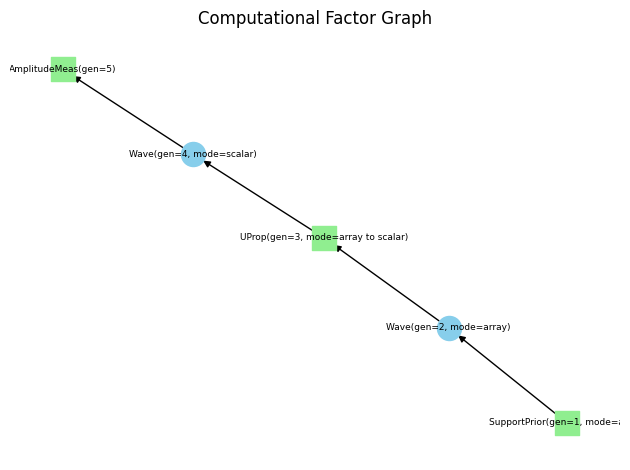

In [4]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)

## Fourier Phase Retrieval

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from core.metrics import pmse
from core.linalg_utils import circular_aperture, random_phase_mask
from graph.structure.graph import Graph
from graph.prior.support_prior import SupportPrior
from graph.propagator.phase_mask_propagator import PhaseMaskPropagator
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement
# ==== 1. パラメータ ====
H, W = 256, 256
shape = (H, W)
var = 1e-4
support_radius = 0.32
rng = np.random.default_rng(seed=42)

class StructuredRandomGraph(Graph):
    def __init__(self):
        super().__init__()
        support = circular_aperture(shape, radius=support_radius)
        self.X = SupportPrior(support=support)
        # Structured random layers (D₁F D₂F D₃F)
        phase1 = random_phase_mask(shape, rng=rng)
        self.Y1 = PhaseMaskPropagator(phase1) @ self.X
        self.Y2 = FFT2DPropagator(shape=shape) @ self.Y1
        phase2 = random_phase_mask(shape, rng=rng)
        self.Y3 = PhaseMaskPropagator(phase2) @ self.Y2
        self.Y4 = FFT2DPropagator(shape=shape) @ self.Y3
        # Final measurement
        self.Z = AmplitudeMeasurement(self.Y4, var=var, damping=0.3)

        self.compile()

# ==== 3. 初期化とデータ生成 ====
g = StructuredRandomGraph()
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=999))
true_x = g.X.get_sample()
g.Z.update_observed_from_sample()

# ==== 4. 推論 ====
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = pmse(est, true_x)
    if t % 20 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=200, callback=monitor)
print("Oversampling Ration = ", 1/(support_radius**2 * np.pi))

[t=0] PMSE = 6.38548e-01
[t=20] PMSE = 3.28026e-01
[t=40] PMSE = 3.17933e-01
[t=60] PMSE = 3.13003e-01
[t=80] PMSE = 3.08306e-01
[t=100] PMSE = 2.38245e-01
[t=120] PMSE = 4.00014e-04
[t=140] PMSE = 2.49607e-04
[t=160] PMSE = 2.49254e-04
[t=180] PMSE = 2.49246e-04
Oversampling Ration =  3.108494982263581


In [6]:
%prun -l 40 -s cumulative g.run(n_iter=200, callback=monitor)

[t=0] PMSE = 2.49245e-04
[t=20] PMSE = 2.49245e-04
[t=40] PMSE = 2.49245e-04
[t=60] PMSE = 2.49245e-04
[t=80] PMSE = 2.49245e-04
[t=100] PMSE = 2.49245e-04
[t=120] PMSE = 2.49245e-04
[t=140] PMSE = 2.49245e-04
[t=160] PMSE = 2.49245e-04
[t=180] PMSE = 2.49245e-04
 

         137515 function calls in 4.082 seconds

   Ordered by: cumulative time
   List reduced from 134 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    4.082    4.082 {built-in method builtins.exec}
        1    0.000    0.000    4.082    4.082 <string>:1(<module>)
        1    0.001    0.001    4.082    4.082 graph.py:84(run)
      200    0.014    0.000    2.954    0.015 graph.py:79(backward)
      400    0.014    0.000    2.095    0.005 fft_2d_propagator.py:104(backward)
      400    0.386    0.001    1.635    0.004 fft_2d_propagator.py:55(compute_belief)
     1000    1.022    0.001    1.029    0.001 uncertain_array.py:164(__truediv__)
      800    0.031    0.000    0.795    0.001 _pocketfft.py:701(_raw_fftnd)
     1600    0.004    0.000    0.744    0.000 _pocketfft.py:49(_raw_fft)
     1600    0.735    0.000    0.735    0.000 {built-in method numpy.fft._pocketfft_internal.execute}
      200    0.0

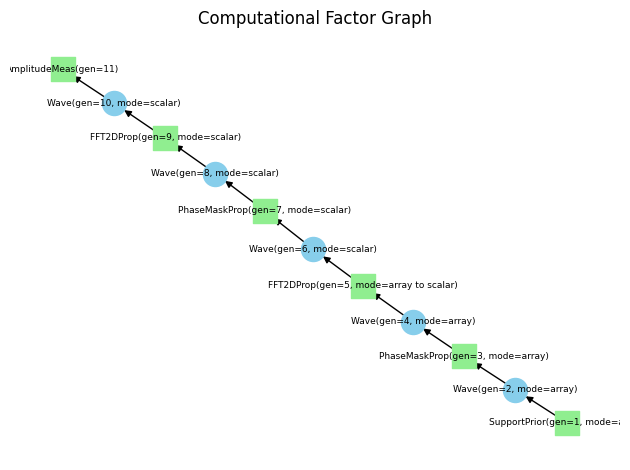

In [7]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)